# Clustering Instacart Market Basket Data - Complete Analysis

This notebook discusses the following topics

<ol>
<li>Data Preprocessing</li>
<li>Dimensionality Reduction using SparsePCA</li>
<li>Clustering model training using different clustering algorithms</li>
<li>Cluster validation using Silhouette coefficient</li>
<li>Data visualization</li>
<li>Cluster Analysis</li>
<li>Sampling Representative dataset</li>
</ol>

In [1]:
import numpy as np 
import pandas as pd
from sklearn.decomposition import SparsePCA
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import Birch
from sklearn.cluster import MiniBatchKMeans
from sklearn import mixture

## Reading data

The entire dataset can be downloaded from <a href="https://www.instacart.com/datasets/grocery-shopping-2017">here</a>. <br>

In [2]:
#Retrieving orders details of all customers
orders = pd.read_csv('data/orders.csv')
print(orders.shape)
orders.head()

(3421083, 7)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [3]:
#Retrieving the previously ordered products of the customers - prior
pdtprior = pd.read_csv('data/order_products__prior.csv')
print(pdtprior.shape)
pdtprior.head(10)

(32434489, 4)


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
5,2,17794,6,1
6,2,40141,7,1
7,2,1819,8,1
8,2,43668,9,0
9,3,33754,1,1


In [4]:
#Retrieving the previously ordered products of the customers - training
pdttrain = pd.read_csv('data/order_products__train.csv')
print(pdttrain.shape)
pdttrain.head()

(1384617, 4)


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [5]:
#merging all the ordered product details in one dataframe
#pdtsOrdered = pd.merge(pdtprior,pdttrain,on=['order_id','order_id'])
pdtsOrdered = pd.concat([pdtprior,pdttrain],axis=0).reset_index()
print(pdtsOrdered.shape)
pdtsOrdered.tail(10)

(33819106, 5)


,index,order_id,product_id,add_to_cart_order,reordered
33819096,1384607,3421058,30316,6,1
33819097,1384608,3421058,35578,7,0
33819098,1384609,3421058,32650,8,1
33819099,1384610,3421063,49235,1,1
33819100,1384611,3421063,13565,2,1
33819101,1384612,3421063,14233,3,1
33819102,1384613,3421063,35548,4,1
33819103,1384614,3421070,35951,1,1
33819104,1384615,3421070,16953,2,1
33819105,1384616,3421070,4724,3,1


In [6]:
#Retrieving the list of products
products = pd.read_csv('data/products.csv')
print(products.shape)
products.head()

(49688, 4)


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [7]:
#Retrieving the list of aisles
aisles = pd.read_csv('data/aisles.csv')
print(aisles.shape)
aisles.head()

(134, 2)


,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [8]:
#Merging orders, products ordered before, products and aisles
pdtlist = pd.merge(pdtsOrdered,products, on = ['product_id','product_id'])
orderslist = pd.merge(pdtlist,orders,on=['order_id','order_id'])
orderslist = pd.merge(orderslist,aisles,on=['aisle_id','aisle_id'])
orderslist.head(10)

,index,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle
0,0,2,33120,1,1,Organic Egg Whites,86,16,202279,prior,3,5,9,8.0,eggs
1,237,26,33120,5,0,Organic Egg Whites,86,16,153404,prior,2,0,16,7.0,eggs
2,1084,120,33120,13,0,Organic Egg Whites,86,16,23750,prior,11,6,8,10.0,eggs
3,3039,327,33120,5,1,Organic Egg Whites,86,16,58707,prior,21,6,9,8.0,eggs
4,3709,390,33120,28,1,Organic Egg Whites,86,16,166654,prior,48,0,12,9.0,eggs
5,5055,537,33120,2,1,Organic Egg Whites,86,16,180135,prior,15,2,8,3.0,eggs
6,5544,582,33120,7,1,Organic Egg Whites,86,16,193223,prior,6,2,19,10.0,eggs
7,5838,608,33120,5,1,Organic Egg Whites,86,16,91030,prior,11,3,21,12.0,eggs
8,5986,623,33120,1,1,Organic Egg Whites,86,16,37804,prior,63,3,12,3.0,eggs
9,6635,689,33120,4,1,Organic Egg Whites,86,16,108932,prior,16,1,13,3.0,eggs


In [9]:
orderslist.shape

(33819106, 15)

## Data Preprocessing

<ol>
<li>Checking for the missing and null values</li>
<li>Removing irrelevant and unimportant features</li>
</ol>

In [10]:
"""
The top 4 aisle values has much higher values from other aisles.
Since all the four are almost visited by every customer.
"""
orderslist['aisle'].value_counts()[0:10]

fresh fruits                     3792661
fresh vegetables                 3568630
packaged vegetables fruits       1843806
yogurt                           1507583
packaged cheese                  1021462
milk                              923659
water seltzer sparkling water     878150
chips pretzels                    753739
soy lactosefree                   664493
bread                             608469
Name: aisle, dtype: int64

In [11]:
"""
PREPROCESSING
"fresh fruits","fresh vegetables","packaged vegetables fruits","yogurt"
The above mentioned aisles are almost in every order.
So, avoiding these aisles and the remaining aisles are focused for targeted marketing.
"""
orderslist.query('aisle != ["fresh fruits","fresh vegetables","packaged vegetables fruits","yogurt"]',inplace=True)

In [12]:
len(orderslist['aisle'].unique())

130

In [13]:
#After removing the columns which has much higher values from other aisles
orderslist['aisle'].value_counts()[0:10]

packaged cheese                  1021462
milk                              923659
water seltzer sparkling water     878150
chips pretzels                    753739
soy lactosefree                   664493
bread                             608469
refrigerated                      599109
frozen produce                    545107
ice cream ice                     521101
crackers                          478430
Name: aisle, dtype: int64

### Dataframe formed to input to clustering model

<b>Dataframe size: </b> (206034, 130) approximately 20M cells
    
Each column represents the aisle. And, each row represents the user and the corresponding purchases in all the aisles.

In [14]:
"""
Products count - 49688
Aisle count - 130 (After preprocessing)
Aisles are a list of categories which groups the similar products together
So,  the customers are clustered based on the aisle information.
"""
user_purchase = pd.crosstab(orderslist['user_id'],orderslist['aisle'])
user_purchase.head(10)

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spirits,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,3,0,0,0,0,2,0,0,0,...,0,3,1,1,0,0,0,0,2,0
3,0,0,0,0,0,0,0,0,0,0,...,0,4,1,0,0,0,0,0,2,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
5,1,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,1,0,0,0,0,1,0,0,0,...,0,0,0,1,1,0,0,0,0,0
9,0,0,0,0,6,0,2,0,0,0,...,0,0,0,0,0,0,0,0,3,0


In [15]:
"""
Database shape : (206034,130) (> 20M cells)
"""
user_purchase.shape

(206034, 130)

In [16]:
"""
PRE-PROCESSING
checking for missing and null values
"""
print(user_purchase.columns[user_purchase.isnull().any()])
print(user_purchase.columns[user_purchase.isna().any()])

Index([], dtype='object', name='aisle')
Index([], dtype='object', name='aisle')


In [17]:
"""
PRE-PROCESSING
The spaces in column names are replaced by underscore to avoid errors in dataframe operations.
"""
user_purchase.columns = [column.replace(" ","_") for column in user_purchase.columns]
user_purchase.head(10)

,air_fresheners_candles,asian_foods,baby_accessories,baby_bath_body_care,baby_food_formula,bakery_desserts,baking_ingredients,baking_supplies_decor,beauty,beers_coolers,...,spirits,spreads,tea,tofu_meat_alternatives,tortillas_flat_bread,trail_mix_snack_mix,trash_bags_liners,vitamins_supplements,water_seltzer_sparkling_water,white_wines
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,3,0,0,0,0,2,0,0,0,...,0,3,1,1,0,0,0,0,2,0
3,0,0,0,0,0,0,0,0,0,0,...,0,4,1,0,0,0,0,0,2,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
5,1,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,1,0,0,0,0,1,0,0,0,...,0,0,0,1,1,0,0,0,0,0
9,0,0,0,0,6,0,2,0,0,0,...,0,0,0,0,0,0,0,0,3,0


In [18]:
# To fetch the list of aisle-names given a keyword
for column in user_purchase.columns:
    if("baby" in column):
        print(column)

baby_accessories
baby_bath_body_care
baby_food_formula


## Dimensionality Reduction

In [18]:
"""
DIMENSIONALITY REDUCTION - using SparsePCA
"""
pca_samples = SparsePCA(n_components=6).fit_transform(user_purchase)
print(pca_samples)

[[ 4.91480234e+00 -2.22244204e-01 -2.18692210e+00 -3.06409010e-01
   2.52652402e+00  3.12239639e+00]
 [-7.05653710e+00  1.25851651e+00 -2.84518653e+00  1.13170064e+01
   1.07329866e+01  1.43131486e+00]
 [ 4.59301625e+00 -7.73364522e-02 -7.41888660e-01  3.20056589e-02
   4.02196771e+00 -4.19567590e+00]
 ...
 [-1.10340368e+01  1.94251989e+00 -6.92719230e-01 -4.69772457e+00
  -6.57775973e+00  6.06407291e+00]
 [-5.73147916e+01 -1.03251860e+01 -1.97597405e+01  4.87622930e+00
  -9.69596977e+00  3.71649054e+00]
 [-2.39643069e+00 -2.15270074e+00 -4.85867235e+00 -1.52111068e+00
   1.09732704e+00  1.06721805e+00]]


In [31]:
"""
DIMENSIONALITY REDUCTION - using PCA (not used)
"""
from sklearn.decomposition import PCA

def dr_using_pca(components):
    #pca = PCA(0.95)
    pca = PCA(n_components=6)
    pca.fit(cust_prod)
    pca_samples = pca.transform(cust_prod)
    print(pca.n_components_)
    print(pca.explained_variance_ratio_)

6
[0.22095233 0.07396947 0.05953613 0.04526231 0.035989   0.03536458]


In [19]:
#converting pca result to dataframe
dr_samples = pd.DataFrame(pca_samples)
print(dr_samples.shape)
dr_samples.head()

(206034, 6)


,0,1,2,3,4,5
0,4.914802,-0.222244,-2.186922,-0.306409,2.526524,3.122396
1,-7.056537,1.258517,-2.845187,11.317006,10.732987,1.431315
2,4.593016,-0.077336,-0.741889,0.032006,4.021968,-4.195676
3,12.684742,0.031870,0.311738,0.695567,0.660967,0.658622
4,11.257591,-1.576486,-1.433090,-1.556261,-1.284189,1.786849


## Choosing the number of PCA components for clustering using Silhouette Analysis

In [77]:
"""
choosing the number of components which has better silhouette score
Finalized: three components
"""
three_clusters = []
four_clusters = []
for i in range(2,7):
    print("number of components:",i)
    comp_list = []
    for j in range(i):
        comp_list.append(j)
    tocluster = pd.DataFrame(dr_samples[comp_list])
    
    for k in range(3,5):
        c_preds = KMeans(n_clusters=k).fit_predict(tocluster)
        silhouette_avg = silhouette_score(tocluster, c_preds)
        print("For no of clusters = %d,The average silhouette_score is : %f"%(k,silhouette_avg))
        if(k == 3):
            three_clusters.append(silhouette_avg)
        else:
            four_clusters.append(silhouette_avg)

number of components: 2
For no of clusters = 3,The average silhouette_score is : 0.620455
For no of clusters = 4,The average silhouette_score is : 0.613140
number of components: 3
For no of clusters = 3,The average silhouette_score is : 0.710357
For no of clusters = 4,The average silhouette_score is : 0.584358
number of components: 4
For no of clusters = 3,The average silhouette_score is : 0.686261
For no of clusters = 4,The average silhouette_score is : 0.549130
number of components: 5
For no of clusters = 3,The average silhouette_score is : 0.672949
For no of clusters = 4,The average silhouette_score is : 0.527855
number of components: 6
For no of clusters = 3,The average silhouette_score is : 0.660716
For no of clusters = 4,The average silhouette_score is : 0.511076


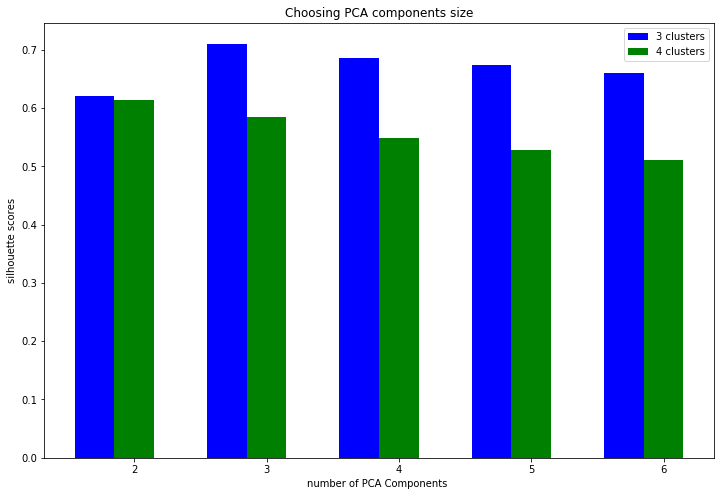

In [37]:
"""
Plotting number of components(Dimensions) against silhouette score
"""
x = np.asarray([2,3,4,5,6])
w = 0.3

plt.figure(figsize=(12,8))
ax = plt.subplot(111)
bar1 = ax.bar(x-w, three_clusters, width=w, color='b', align='center')
bar2 = ax.bar(x, four_clusters, width=w, color='g', align='center')
ax.set_ylabel('silhouette scores')
ax.set_xlabel('number of PCA Components ')
ax.legend((bar1[0],bar2[0]), ('3 clusters', '4 clusters'))
ax.set_title("Choosing PCA components size")
plt.show()

For no of clusters = 3, The average silhouette_score is : 0.6221333946729004
For no of clusters = 4, The average silhouette_score is : 0.6129120445979189


c:\users\aravind\appdata\local\programs\python\python37\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


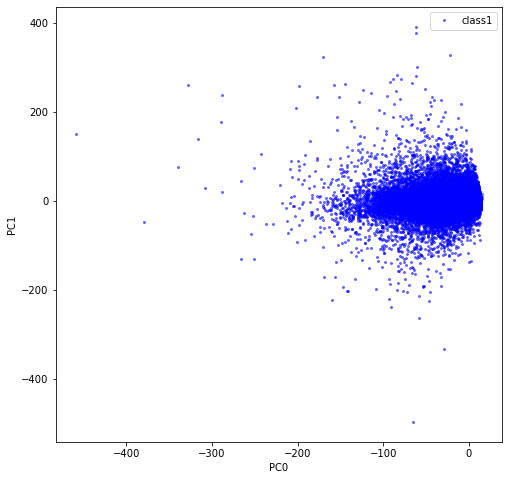

_______________________________________________________________
For no of clusters = 3, The average silhouette_score is : 0.6257833720310999
For no of clusters = 4, The average silhouette_score is : 0.6239093523365462


c:\users\aravind\appdata\local\programs\python\python37\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


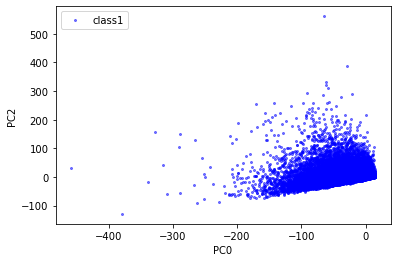

_______________________________________________________________
For no of clusters = 3, The average silhouette_score is : 0.6320430623473394
For no of clusters = 4, The average silhouette_score is : 0.6225930886499563


c:\users\aravind\appdata\local\programs\python\python37\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


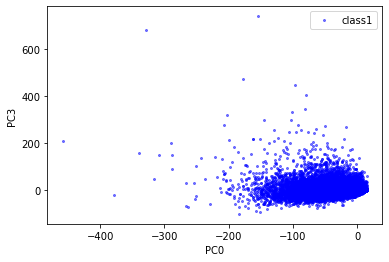

_______________________________________________________________
For no of clusters = 3, The average silhouette_score is : 0.632681596320213
For no of clusters = 4, The average silhouette_score is : 0.5571826039053046


c:\users\aravind\appdata\local\programs\python\python37\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


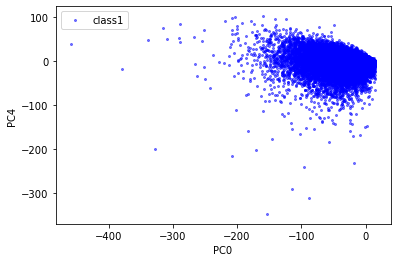

_______________________________________________________________
For no of clusters = 3, The average silhouette_score is : 0.6306012236033053
For no of clusters = 4, The average silhouette_score is : 0.5608569342877393


c:\users\aravind\appdata\local\programs\python\python37\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


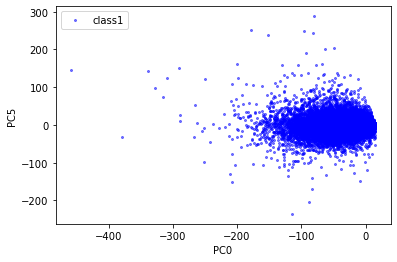

_______________________________________________________________
For no of clusters = 3, The average silhouette_score is : 0.8305856533275445
For no of clusters = 4, The average silhouette_score is : 0.681738084926455


c:\users\aravind\appdata\local\programs\python\python37\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


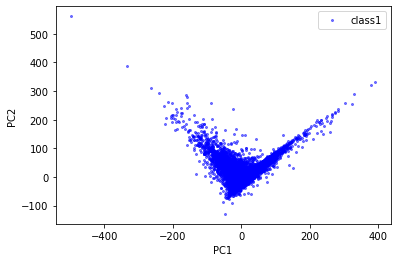

_______________________________________________________________
For no of clusters = 3, The average silhouette_score is : 0.7776022170874675
For no of clusters = 4, The average silhouette_score is : 0.7033746291353685


c:\users\aravind\appdata\local\programs\python\python37\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


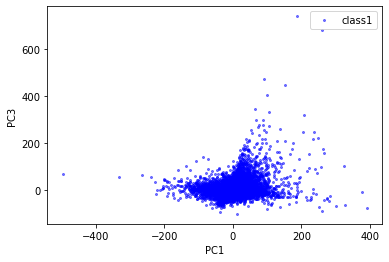

_______________________________________________________________
For no of clusters = 3, The average silhouette_score is : 0.7685144665476156
For no of clusters = 4, The average silhouette_score is : 0.6791977695309083


c:\users\aravind\appdata\local\programs\python\python37\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


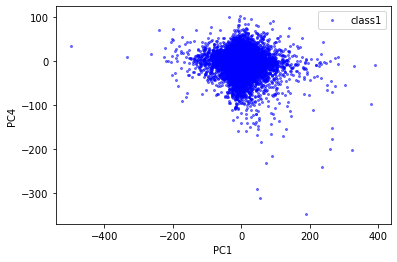

_______________________________________________________________
For no of clusters = 3, The average silhouette_score is : 0.7797255232957788
For no of clusters = 4, The average silhouette_score is : 0.6004787748792639


c:\users\aravind\appdata\local\programs\python\python37\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


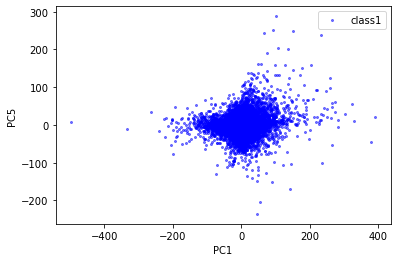

_______________________________________________________________
For no of clusters = 3, The average silhouette_score is : 0.8307579030779751
For no of clusters = 4, The average silhouette_score is : 0.5809799894675932


c:\users\aravind\appdata\local\programs\python\python37\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


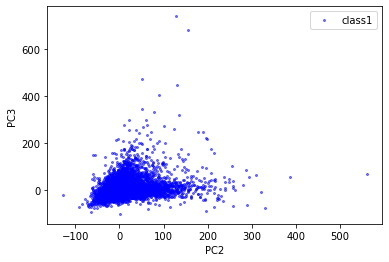

_______________________________________________________________
For no of clusters = 3, The average silhouette_score is : 0.6761702143374487
For no of clusters = 4, The average silhouette_score is : 0.6692822701319131


c:\users\aravind\appdata\local\programs\python\python37\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


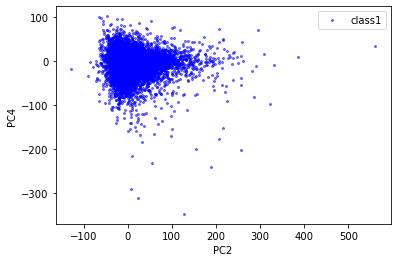

_______________________________________________________________
For no of clusters = 3, The average silhouette_score is : 0.5658905378032885
For no of clusters = 4, The average silhouette_score is : 0.5968161164206889


c:\users\aravind\appdata\local\programs\python\python37\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


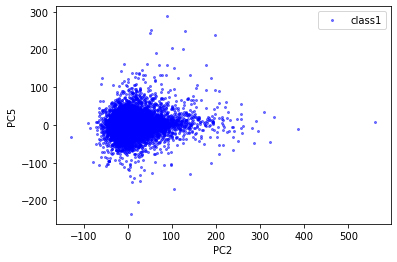

_______________________________________________________________
For no of clusters = 3, The average silhouette_score is : 0.68108739416207
For no of clusters = 4, The average silhouette_score is : 0.6858770372571223


c:\users\aravind\appdata\local\programs\python\python37\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


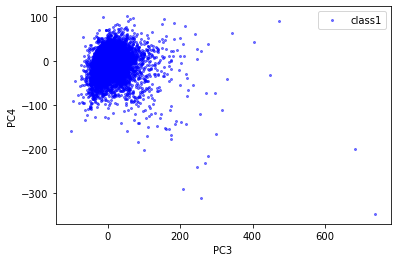

_______________________________________________________________
For no of clusters = 3, The average silhouette_score is : 0.6446749953450959
For no of clusters = 4, The average silhouette_score is : 0.6538225919686991


c:\users\aravind\appdata\local\programs\python\python37\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


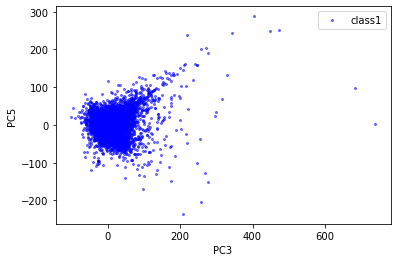

_______________________________________________________________
For no of clusters = 3, The average silhouette_score is : 0.6037978646398752
For no of clusters = 4, The average silhouette_score is : 0.5998767463841962


c:\users\aravind\appdata\local\programs\python\python37\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


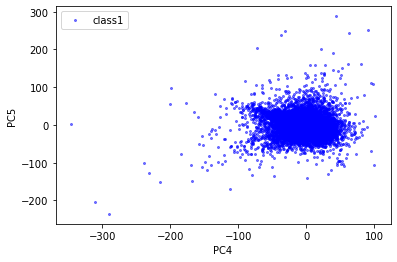

_______________________________________________________________


In [78]:
"""
principal components are plotted against each other to select two dimensional components.
Some components gave higher silhouette score, but it causes overfitting when clustering the customers
It grouped 80% of the customers in the same cluster, and only remaining 20% were distributed.
It was same in the case of both (1,2), (2,3)

This analysis is not used since the higher values seems to group most of the customers in the same cluster.
"""
fig = plt.figure(figsize=(8,8))
jstart = 0
clusternum = 3
pcpairs = []
silscores = []
for i in range(6):
    jstart += 1
    for j in range(jstart,6):
        pcpairs.append("("+str(i)+","+str(j)+")")
        tocluster = pd.DataFrame(dr_samples[[i,j]])
        
        #forming 3 clusters and finding silhouette score
        c_preds = KMeans(n_clusters=clusternum).fit_predict(tocluster)
        silhouette_avg = silhouette_score(tocluster, c_preds)
        print("For no of clusters = 3, The average silhouette_score is :", silhouette_avg)
        silscores.append(silhouette_avg)

        #forming 4 clusters and finding silhouette score
        c_preds = KMeans(n_clusters=clusternum+1).fit_predict(tocluster)
        silhouette_avg = silhouette_score(tocluster, c_preds)
        print("For no of clusters = 4, The average silhouette_score is :", silhouette_avg)
        
        plt.plot(tocluster[i], tocluster[j],'o',markersize=2,color='blue',alpha=0.5,label='class1')
        plt.xlabel('PC'+str(i))
        plt.ylabel('PC'+str(j))
        plt.legend()
        plt.show()
        print("_______________________________________________________________")

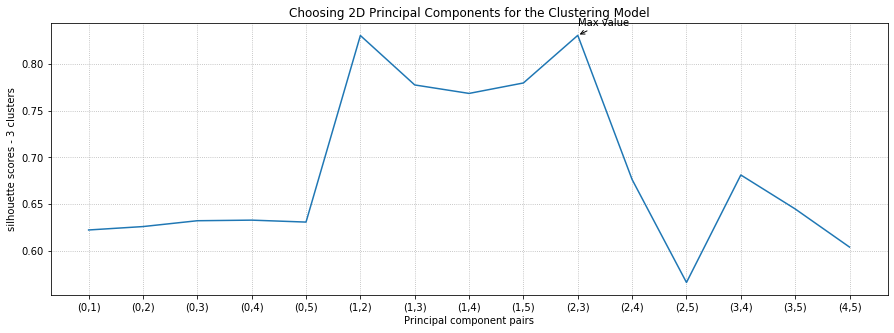

In [50]:
"""
Some components gave higher silhouette score, but it causes overfitting when clustering the customers
It grouped 80% of the customers in the same cluster, and only remaining 20% were distributed.
It was same in the case of both (1,2), (2,3).
So, these components are not chosen for clustering.
"""
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 5)
plt.plot(pcpairs,silscores)

maxy = max(silscores)
xpos = silscores.index(maxy)
maxx = pcpairs[xpos]

plt.annotate('Max value', xy=(maxx, maxy), xytext=(maxx,maxy+0.01),arrowprops=dict(arrowstyle="->"))
plt.xlabel('Principal component pairs')
plt.ylabel('silhouette scores - 3 clusters')
plt.title('Choosing 2D Principal Components for the Clustering Model')
plt.grid(linestyle='dotted')

plt.show()

## Choosing the value of K using Elbow Curve

The elbow curve is drawn based on both distortion and inertia values of clusters formed.

In [173]:
"""
clustering algorithm chosen : KMeans
choosing the value of K using Elbow curve
An Elbow curve is drawn for clusters based on distortion and inertia
"""
from scipy.spatial.distance import cdist 

distortion = []
inertia = []
tocluster = pd.DataFrame(dr_samples[[0,1,2]])

for i in range(1, 11):
    km = KMeans(n_clusters=i)
    km.fit(tocluster)
    
    #append inertia of each cluster size
    inertia.append(km.inertia_)
    
    #append distortion of each cluster size
    distortion.append(sum(np.min(cdist(tocluster, km.cluster_centers_, 'cosine'),axis=1))/tocluster.shape[0])

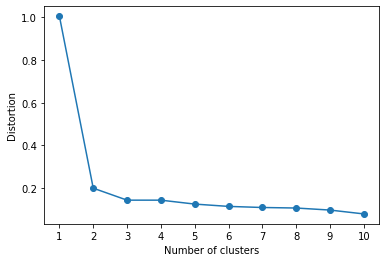

In [174]:
"""
Based on distortion in the columns (0,1,2)
"""
plt.plot(range(1, 11), distortion, marker='o')
plt.xticks(np.arange(1,11, step=1))
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

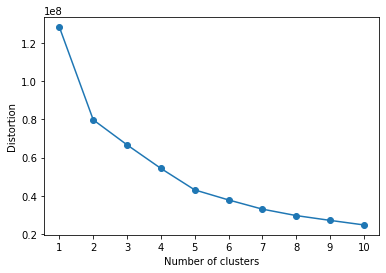

In [175]:
"""
Based on inertia - not an informative Elbow curve
"""
plt.plot(range(1, 11), inertia, marker='o')
plt.xticks(np.arange(1,11, step=1))
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

## Choosing the value of K using Silhouette Analysis

It is an additional check to confirm the value of K (cluster size)

In [179]:
"""
clustering algorithm chosen : KMeans
choosing the value of K using Silhouette score analysis
Additional check to confirm the number of clusters
"""
tocluster = pd.DataFrame(dr_samples[[0,1,2]])
silscores = []
for i in range(2,11):
    c_preds = KMeans(n_clusters=i).fit_predict(tocluster)
    silhouette_avg = silhouette_score(tocluster, c_preds)
    silscores.append(silhouette_avg)
    print("For no of clusters = %d,The average silhouette_score is : %f"%(i,silhouette_avg))

For no of clusters = 2,The average silhouette_score is : 0.711942
For no of clusters = 3,The average silhouette_score is : 0.710364
For no of clusters = 4,The average silhouette_score is : 0.584165
For no of clusters = 5,The average silhouette_score is : 0.584541
For no of clusters = 6,The average silhouette_score is : 0.591888
For no of clusters = 7,The average silhouette_score is : 0.515403
For no of clusters = 8,The average silhouette_score is : 0.518780
For no of clusters = 9,The average silhouette_score is : 0.524185
For no of clusters = 10,The average silhouette_score is : 0.472336


In [180]:
silscores

[0.7119424891549846,
 0.7103644535001636,
 0.5841647186146506,
 0.584540756355738,
 0.5918875883015601,
 0.5154029918607275,
 0.5187797498530825,
 0.5241848465697974,
 0.4723361022969673]

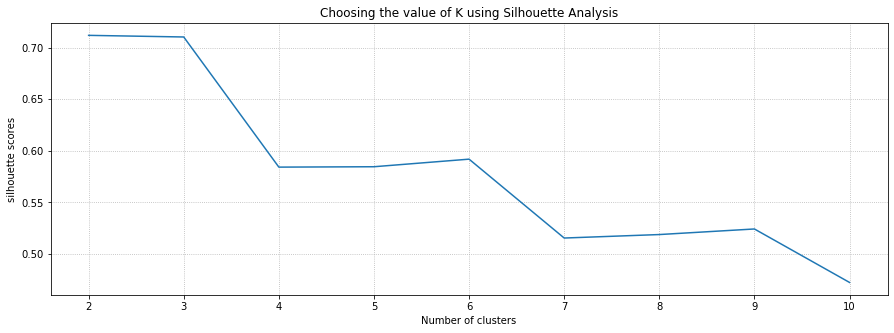

In [182]:
"""
choosing the value of K using Silhouette score analysis
This plot shows the silhouette scores against the number of clusters
"""
plt.rcParams["figure.figsize"] = (15, 5)
plt.plot(range(2,11),silscores)
plt.xlabel('Number of clusters')
plt.ylabel('silhouette scores')
plt.title('Choosing the value of K using Silhouette Analysis')
plt.grid(linestyle='dotted')

plt.show()

### Considering the output of Elbow Curve and Silhouette Analysis, the chosen value for K is 3 

In [20]:
comp1 = 0
comp2 = 1
comp3 = 2
nclusters = 3

In [21]:
tocluster = pd.DataFrame(dr_samples[[comp1,comp2,comp3]])
print(tocluster.head())

           0         1         2
0   4.914802 -0.222244 -2.186922
1  -7.056537  1.258517 -2.845187
2   4.593016 -0.077336 -0.741889
3  12.684742  0.031870  0.311738
4  11.257591 -1.576486 -1.433090


## Data Visualization after dimensionality reduction

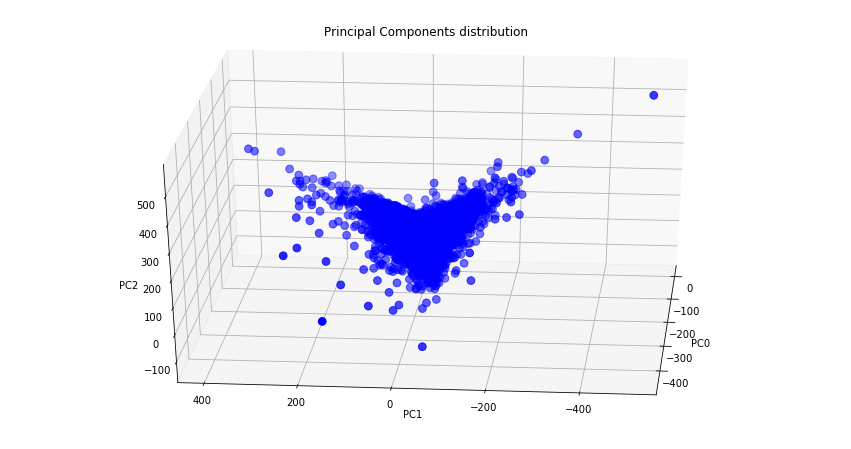

In [218]:
"""
DATA VISUALIZATION
plotting principal components in 3D space
"""
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dr_samples[comp1], dr_samples[comp2], dr_samples[comp3], c='blue', s=60)
ax.set_xlabel('PC0')
ax.set_ylabel('PC1')
ax.set_zlabel('PC2')
ax.set_title('Principal Components distribution')
ax.view_init(30, 185)
plt.show()

## Clustering Model Training

Clustering model is trained using KMeans and validated using Silhouette Coefficient. <br>
MiniBatchKMeans, KMeans, Birch, GaussianMixture, Spectral Clustering are the other algorithms explored. <br>
After the value of K is chosen using Elbow curve and verified with silhouette analysis, the clustering model is trained with the different clustering algorithms and the clustering performance is analysed using Silhouette coefficent.<br>
<br>
<b>Finalized Algorithm: KMeans</b> <br>
<b>Reasons for choosing KMeans</b><br>
<ol>
<li>Better results on the cluster validity check comparing to the other clustering algorithms.</li>
<li>The data distribution seems not to have differing sizes/shapes/density which affects KMeans performance. Eventhough it has outliers, those are given importance in this problem since it denotes higher purchase rate.</li>
<li>Model training time is pretty fast in KMeans. Besides avoiding complex and memory consuming calculations like in spectral clustering or affinity propogation, KMeans also provides better performance.</li>
</ol>

In [22]:
"""
CLUSTERING MODELS
created dictionary of various clustering models
"""
def get_clusterer(clusterer = "KMEANS", nclusters = 3):
    clusterer_dict = {
        "KMEANS": KMeans(n_clusters=nclusters, random_state=21),
        "MBKM": MiniBatchKMeans(init='k-means++', n_clusters=nclusters,
                      n_init=10, max_no_improvement=10, verbose=0),
        "BIRCH" : Birch(n_clusters=nclusters),
        "GM" : mixture.GaussianMixture(n_components=nclusters, covariance_type='full')
        #Spectralclustering takes too long time
        #"SC" : SpectralClustering(n_clusters=nclusters,assign_labels="discretize",random_state=21)        
    }
    return clusterer_dict[clusterer]

In [23]:
"""
Clustering model training
"""
clustering_algo = "KMEANS"
clusterer = get_clusterer(clusterer=clustering_algo, nclusters=nclusters)
clusterer.fit(tocluster)

if(clustering_algo == "KMEANS" ):
    centers = clusterer.cluster_centers_

c_preds = clusterer.predict(tocluster)
print(c_preds[0:100])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0]


## Cluster Validity check

In [25]:
"""
CLUSTER VALIDITY - Silhouette Coefficient
Predicting silhouette score for formed clusters
""" 
#silscores_algo = []
silhouette_avg = silhouette_score(tocluster, c_preds) 
print("For no of clusters = ",nclusters, 
          " The average silhouette_score is :", silhouette_avg)
#silscores_algo.append(silhouette_avg)

For no of clusters =  3  The average silhouette_score is : 0.7103573266203149


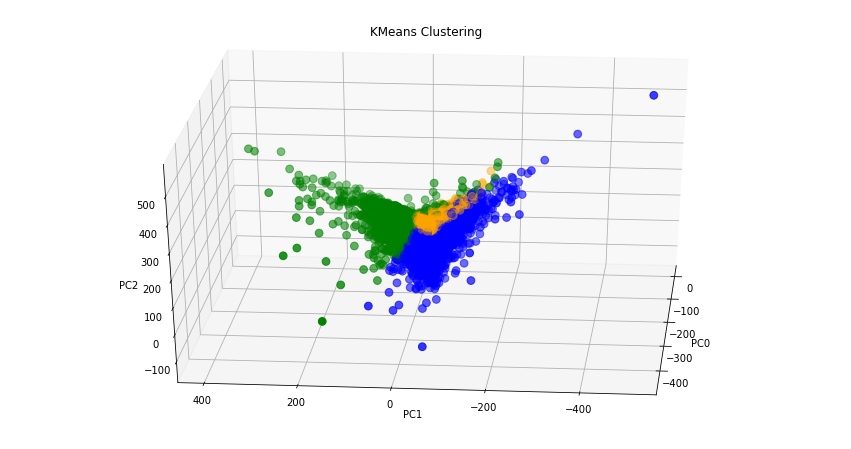

In [78]:
"""
To check how clusters are formed
"""
%matplotlib inline


from mpl_toolkits.mplot3d import Axes3D

colors = ['orange','blue','green','purple']
#colors = ['orange','blue','green']
colored = [colors[k] for k in c_preds]
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dr_samples[0], dr_samples[1], dr_samples[2], c=colored, s=60)
ax.view_init(30, 185)
ax.set_xlabel('PC0')
ax.set_ylabel('PC1')
ax.set_zlabel('PC2')
ax.set_title('KMeans Clustering')
plt.show()

## Silhouette Analysis for KMeans clustering output

n_clusters =  3 The silhouette_score is : 0.7103620694106347
n_clusters =  4 The silhouette_score is : 0.5856538935050242
n_clusters =  5 The silhouette_score is : 0.584503505406592
n_clusters =  6 The silhouette_score is : 0.5917105990112439


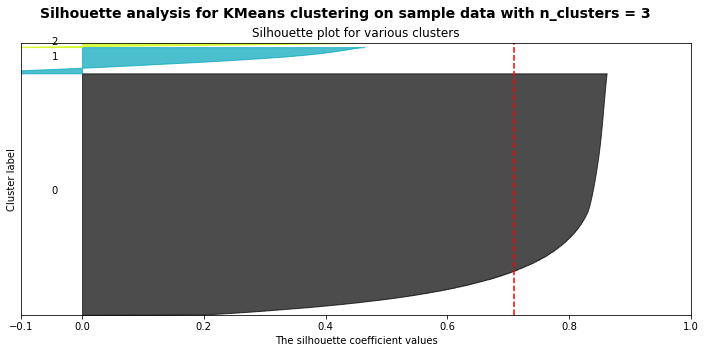

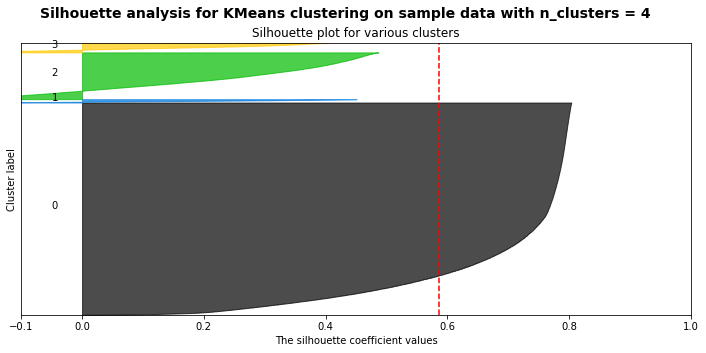

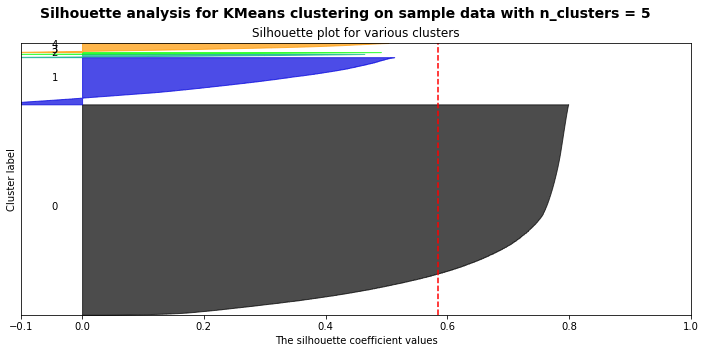

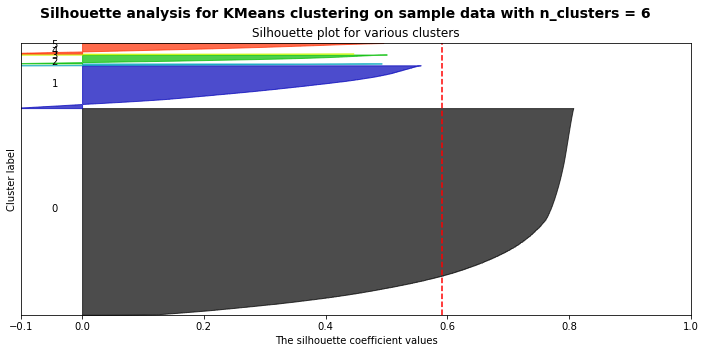

In [181]:
"""
Detailed analysis of clustering for the cluster size 3-6
"""
import matplotlib.cm as cm

cluster_size = [3, 4, 5, 6]

X = pd.DataFrame(dr_samples[[0,1,2]])
for n_clusters in cluster_size:
    fig, ax1 = plt.subplots(1)
    fig.set_size_inches(12, 5)

    # first subplot - silhouette plot
    # setting x axis limit
    ax1.set_xlim([-0.1, 1])
    
    # setting y-axis limit
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # KMeans clustering
    clusterer = KMeans(n_clusters=n_clusters)
    c_preds = clusterer.fit_predict(X)

    # silhouette score gives the info about the cluster formation
    # how well cluster's intra-cluster distance is decreased and inter-cluster distance is increased
    silhouette_avg = silhouette_score(X, c_preds)
    print("n_clusters = ", n_clusters,"The silhouette_score is :", silhouette_avg)

    # silhouette score for each sample
    sil_samples = silhouette_samples(X, c_preds)


    y_end = 10
    for i in range(n_clusters):
        each_cluster_values = sil_samples[c_preds == i]
        each_cluster_values.sort()

        each_cluster_size = each_cluster_values.shape[0]
        y_start = y_end + each_cluster_size

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_end, y_start),0, each_cluster_values,facecolor=color, edgecolor=color, alpha=0.7)

        #silhouette plots label
        ax1.text(-0.05, y_end + 0.5 * each_cluster_size, str(i))

        # new ylower value
        y_end = y_start + 10

    ax1.set_title("Silhouette plot for various clusters")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # red line shows the average silhouette score
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

It is noticed from the silhouette analysis for KMeans clustering that mostly items are grouped into cluster 0(first cluster).
So, Cluster 0 holds all the general products which is common among the customers. And, the other variations are captured
in the remaining clusters.

### Final dataframe with cluster output

This dataframe is used for targeted marketing where the list of common buyers (user ids) can be found given the aisle. <br>

In [24]:
prod_clusters = user_purchase.copy()
prod_clusters['cluster'] = c_preds

prod_clusters.head(20)

,air_fresheners_candles,asian_foods,baby_accessories,baby_bath_body_care,baby_food_formula,bakery_desserts,baking_ingredients,baking_supplies_decor,beauty,beers_coolers,...,spreads,tea,tofu_meat_alternatives,tortillas_flat_bread,trail_mix_snack_mix,trash_bags_liners,vitamins_supplements,water_seltzer_sparkling_water,white_wines,cluster
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,0,3,0,0,0,0,2,0,0,0,...,3,1,1,0,0,0,0,2,0,0
3,0,0,0,0,0,0,0,0,0,0,...,4,1,0,0,0,0,0,2,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
5,1,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,1,0,0,0,0,1,0,0,0,...,0,0,1,1,0,0,0,0,0,0
9,0,0,0,0,6,0,2,0,0,0,...,0,0,0,0,0,0,0,3,0,0


In [25]:
"""
converting output dataframe as csv file for testing usecases
"""
prod_clusters.to_csv("cluster_output.gz")

### Cluster Output Visualization

The below graph represents the distribution of aisles(product categories) in each cluster.

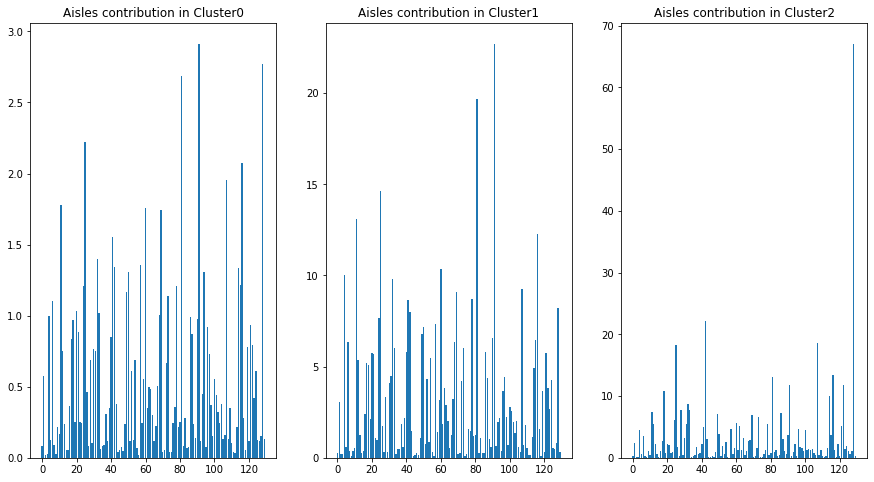

In [26]:
fig,(a1,a2,a3) = plt.subplots(1,3,sharex=True, figsize=(15,8))

c0 = prod_clusters[prod_clusters['cluster']==0].drop('cluster',axis=1).mean()
a1.bar(range(len(prod_clusters.drop('cluster',axis=1).columns)),c0)
a1.set_title('Aisles contribution in Cluster0')

c1 = prod_clusters[prod_clusters['cluster']==1].drop('cluster',axis=1).mean()
a2.bar(range(len(prod_clusters.drop('cluster',axis=1).columns)),c1)
a2.set_title('Aisles contribution in Cluster1')

c2 = prod_clusters[prod_clusters['cluster']==2].drop('cluster',axis=1).mean()
a3.bar(range(len(prod_clusters.drop('cluster',axis=1).columns)),c2)
a3.set_title('Aisles contribution in Cluster2')

plt.show()

### Top 20 products in all the three clusters formed

In [80]:
c0.sort_values(ascending=False)[0:20]

packaged_cheese                  2.913742
water_seltzer_sparkling_water    2.768419
milk                             2.689072
chips_pretzels                   2.218732
soy_lactosefree                  2.071760
refrigerated                     1.951801
bread                            1.777537
frozen_produce                   1.758788
ice_cream_ice                    1.741843
eggs                             1.556204
crackers                         1.400169
frozen_meals                     1.356707
energy_granola_bars              1.343115
soft_drinks                      1.338685
packaged_produce                 1.306596
fresh_herbs                      1.306209
soup_broth_bouillon              1.213122
cereal                           1.211417
lunch_meat                       1.209063
fresh_dips_tapenades             1.169916
dtype: float64

In [81]:
c1.sort_values(ascending=False)[0:20]

packaged_cheese                  22.711699
milk                             19.663314
chips_pretzels                   14.630470
bread                            13.094960
soy_lactosefree                  12.265768
frozen_produce                   10.344633
baby_food_formula                10.031486
crackers                          9.826074
refrigerated                      9.266120
ice_cream_ice                     9.088321
lunch_meat                        8.732924
eggs                              8.643597
water_seltzer_sparkling_water     8.229504
energy_granola_bars               8.019867
cereal                            7.689367
frozen_meals                      7.327633
fresh_herbs                       7.170858
fresh_dips_tapenades              6.772558
other_creams_cheeses              6.576602
soup_broth_bouillon               6.438336
dtype: float64

In [82]:
c2.sort_values(ascending=False)[0:20]

water_seltzer_sparkling_water    67.083629
energy_granola_bars              22.124637
refrigerated                     18.596384
chips_pretzels                   18.309977
soy_lactosefree                  13.360995
milk                             13.065870
packaged_cheese                  11.796254
tea                              11.781724
candy_chocolate                  10.861802
soft_drinks                       9.951566
crackers                          8.640620
cream                             7.724572
coffee                            7.702615
bread                             7.338715
nuts_seeds_dried_fruit            7.185664
fresh_dips_tapenades              7.108815
ice_cream_ice                     6.959638
juice_nectars                     6.647401
cereal                            6.183726
frozen_produce                    5.644172
dtype: float64

## Cluster Analysis

There are three clusters formed here. Each cluster has the domination of certain aisles and its related products.
To analyse this, all the three clusters are created as a dataframe as shown below.

In [32]:
clusterMean = pd.DataFrame([c0,c1,c2], columns = prod_clusters.drop(['cluster'],axis=1).columns)
#clusterMean = pd.DataFrame([c0,c1,c2,c3], columns = prod_clusters.drop(['cluster'],axis=1).columns)
clusterMean.head()

,air_fresheners_candles,asian_foods,baby_accessories,baby_bath_body_care,baby_food_formula,bakery_desserts,baking_ingredients,baking_supplies_decor,beauty,beers_coolers,...,spirits,spreads,tea,tofu_meat_alternatives,tortillas_flat_bread,trail_mix_snack_mix,trash_bags_liners,vitamins_supplements,water_seltzer_sparkling_water,white_wines
0,0.082128,0.576373,0.022392,0.026096,0.995253,0.127355,1.106307,0.088028,0.024179,0.218186,...,0.120243,0.933348,0.796569,0.422398,0.608069,0.123799,0.120177,0.150916,2.768419,0.130988
1,0.244895,3.061412,0.199276,0.187154,10.031486,0.570918,6.349663,0.395886,0.085655,0.365959,...,0.305704,5.766170,3.843326,2.650739,4.252087,0.557841,0.503320,0.809174,8.229504,0.331808
2,0.327737,2.337423,0.130772,0.132709,4.527607,0.551501,3.558605,0.258637,0.105263,1.059089,...,0.316435,5.167904,11.781724,1.476590,1.872780,1.065547,0.547627,1.070068,67.083629,0.345819


In the above dataframe, each row represents the cluster. Three rows represents the three clusters formed. And, aisles are
represented as columns.
To find the contribution of each column (aisle) in the cluster, each value is transformed into the percentage which 
denotes each column's contribution.

In [33]:
aisleClusters = clusterMean.iloc[:, :].apply(lambda x: (x / x.sum())*100,axis=1)
aisleClusters.head()

,air_fresheners_candles,asian_foods,baby_accessories,baby_bath_body_care,baby_food_formula,bakery_desserts,baking_ingredients,baking_supplies_decor,beauty,beers_coolers,...,spirits,spreads,tea,tofu_meat_alternatives,tortillas_flat_bread,trail_mix_snack_mix,trash_bags_liners,vitamins_supplements,water_seltzer_sparkling_water,white_wines
0,0.111922,0.785461,0.030515,0.035563,1.356296,0.173555,1.507637,0.119962,0.032950,0.297336,...,0.163862,1.271934,1.085537,0.575629,0.828655,0.168709,0.163773,0.205664,3.772706,0.178506
1,0.058402,0.730078,0.047523,0.044632,2.392282,0.136151,1.514251,0.094410,0.020427,0.087273,...,0.072903,1.375101,0.916546,0.632141,1.014027,0.133033,0.120030,0.192970,1.962551,0.079129
2,0.075930,0.541536,0.030297,0.030746,1.048960,0.127772,0.824460,0.059921,0.024387,0.245371,...,0.073312,1.197304,2.729599,0.342098,0.433887,0.246867,0.126875,0.247914,15.541989,0.080120


From the above dataframe, the percentage of each column contribution in the corresponding cluster can be found. For example, baby food formula represents 2,4% in the third cluster (index-2). And, it seems that baby food formula contributes more in the third cluster, so does baby accessories and baby bath body care. It clearly denotes the third cluster encloses the customers who are buyers of the baby products.

Likewise, each cluster is characterised by few aisles. And, all general items like beauty, laundry, cleaning falls under second cluster (index - 1)

In [28]:
"""
Retrieves the cluster given the aisle name
"""
def get_cluster_for_aisle(aisle_name):
    aisle_name = aisle_name.replace(" ","_")
    return aisleClusters[aisle_name].idxmax()

In [29]:
def get_aisles_for_clusters(cluster):
    aisles=[]
    for column in prod_clusters.drop(['cluster'],axis=1).columns :
        if(cluster == aisleClusters[column].idxmax()):
            aisles.append(column)
            
    return aisles       

In [30]:
"""
Retrieves aisle names
"""
def get_aisles():
    return [column for column in prod_clusters.drop(['cluster'],axis=1).columns]

### Column (Aisle) names

In [63]:
for col in get_aisles():
    print(col)

air_fresheners_candles
asian_foods
baby_accessories
baby_bath_body_care
baby_food_formula
bakery_desserts
baking_ingredients
baking_supplies_decor
beauty
beers_coolers
body_lotions_soap
bread
breakfast_bakery
breakfast_bars_pastries
bulk_dried_fruits_vegetables
bulk_grains_rice_dried_goods
buns_rolls
butter
candy_chocolate
canned_fruit_applesauce
canned_jarred_vegetables
canned_meals_beans
canned_meat_seafood
cat_food_care
cereal
chips_pretzels
cleaning_products
cocoa_drink_mixes
coffee
cold_flu_allergy
condiments
cookies_cakes
crackers
cream
deodorants
diapers_wipes
digestion
dish_detergents
dog_food_care
doughs_gelatins_bake_mixes
dry_pasta
eggs
energy_granola_bars
energy_sports_drinks
eye_ear_care
facial_care
feminine_care
first_aid
food_storage
fresh_dips_tapenades
fresh_herbs
fresh_pasta
frozen_appetizers_sides
frozen_breads_doughs
frozen_breakfast
frozen_dessert
frozen_juice
frozen_meals
frozen_meat_seafood
frozen_pizza
frozen_produce
frozen_vegan_vegetarian
fruit_vegetable_snack

### Aisles mostly visited by the customers belonging to Cluster 0

Cluster 0 encloses all the general items like laundry, cleaning items, body care, frozen foods, meat, etc., <br>
It represents items which are used in regular basis.

In [85]:
c0aisles = get_aisles_for_clusters(0)
print(len(c0aisles))
c0aisles

64


['air_fresheners_candles',
 'asian_foods',
 'bakery_desserts',
 'baking_supplies_decor',
 'beauty',
 'beers_coolers',
 'body_lotions_soap',
 'canned_jarred_vegetables',
 'canned_meat_seafood',
 'cat_food_care',
 'cleaning_products',
 'cocoa_drink_mixes',
 'cold_flu_allergy',
 'condiments',
 'deodorants',
 'digestion',
 'dog_food_care',
 'eggs',
 'eye_ear_care',
 'facial_care',
 'feminine_care',
 'first_aid',
 'food_storage',
 'fresh_herbs',
 'frozen_dessert',
 'frozen_juice',
 'frozen_meals',
 'frozen_meat_seafood',
 'frozen_pizza',
 'frozen_vegan_vegetarian',
 'hair_care',
 'honeys_syrups_nectars',
 'ice_cream_ice',
 'ice_cream_toppings',
 'indian_foods',
 'juice_nectars',
 'kitchen_supplies',
 'kosher_foods',
 'laundry',
 'marinades_meat_preparation',
 'meat_counter',
 'missing',
 'more_household',
 'muscles_joints_pain_relief',
 'oils_vinegars',
 'oral_hygiene',
 'other',
 'packaged_poultry',
 'packaged_produce',
 'packaged_seafood',
 'paper_goods',
 'prepared_soups_salads',
 'prese

#### Get the cluster given the aisle name - Examples for Cluster 0

In [34]:
#Accepts aisle name as an argument
aisle_name = "beauty"
match_cluster = get_cluster_for_aisle(aisle_name)
print("%s belongs to cluster %d"%(aisle_name,match_cluster))

aisle_name = "frozen_pizza"
match_cluster = get_cluster_for_aisle(aisle_name)
print("%s belongs to cluster %d"%(aisle_name,match_cluster))

aisle_name = "laundry"
match_cluster = get_cluster_for_aisle(aisle_name)
print("%s belongs to cluster %d"%(aisle_name,match_cluster))

beauty belongs to cluster 0
frozen_pizza belongs to cluster 0
laundry belongs to cluster 0


### Aisles mostly visited by the customers belonging to Cluster 1

Cluster 1 represents baby products like baby accessories, baby bath body care, baby food formula, diapers wipes, etc., <br> Interestingly, milk is also categorized in this cluster only.

In [86]:
c1aisles = get_aisles_for_clusters(1)
print(len(c1aisles))
c1aisles

40


['baby_accessories',
 'baby_bath_body_care',
 'baby_food_formula',
 'baking_ingredients',
 'bread',
 'breakfast_bakery',
 'bulk_grains_rice_dried_goods',
 'buns_rolls',
 'butter',
 'canned_fruit_applesauce',
 'canned_meals_beans',
 'cereal',
 'crackers',
 'diapers_wipes',
 'dish_detergents',
 'doughs_gelatins_bake_mixes',
 'dry_pasta',
 'fresh_pasta',
 'frozen_appetizers_sides',
 'frozen_breads_doughs',
 'frozen_breakfast',
 'frozen_produce',
 'grains_rice_dried_goods',
 'hot_cereal_pancake_mixes',
 'hot_dogs_bacon_sausage',
 'instant_foods',
 'latino_foods',
 'lunch_meat',
 'milk',
 'other_creams_cheeses',
 'packaged_cheese',
 'packaged_meat',
 'pasta_sauce',
 'pickled_goods_olives',
 'poultry_counter',
 'prepared_meals',
 'specialty_cheeses',
 'spreads',
 'tofu_meat_alternatives',
 'tortillas_flat_bread']

#### Get the cluster given the aisle name - Examples for Cluster 1

In [35]:
#Accepts aisle name as an argument
aisle_name = "baby food formula"
match_cluster = get_cluster_for_aisle(aisle_name)
print("%s belongs to cluster %d"%(aisle_name,match_cluster))

aisle_name = "baby accessories"
match_cluster = get_cluster_for_aisle(aisle_name)
print("%s belongs to cluster %d"%(aisle_name,match_cluster))

aisle_name = "baby bath body care"
match_cluster = get_cluster_for_aisle(aisle_name)
print("%s belongs to cluster %d"%(aisle_name,match_cluster))

aisle_name = "diapers_wipes"
match_cluster = get_cluster_for_aisle(aisle_name)
print("%s belongs to cluster %d"%(aisle_name,match_cluster))

baby food formula belongs to cluster 1
baby accessories belongs to cluster 1
baby bath body care belongs to cluster 1
diapers_wipes belongs to cluster 1


### Aisles mostly visited by the customers belonging to Cluster 2

Cluster 2 represents snacks items like candies, bars, drinks, nuts, etc.,

In [87]:
c2aisles = get_aisles_for_clusters(2)
print(len(c2aisles))
c2aisles

26


['breakfast_bars_pastries',
 'bulk_dried_fruits_vegetables',
 'candy_chocolate',
 'chips_pretzels',
 'coffee',
 'cookies_cakes',
 'cream',
 'energy_granola_bars',
 'energy_sports_drinks',
 'fresh_dips_tapenades',
 'fruit_vegetable_snacks',
 'granola',
 'mint_gum',
 'nuts_seeds_dried_fruit',
 'plates_bowls_cups_flatware',
 'popcorn_jerky',
 'protein_meal_replacements',
 'refrigerated',
 'skin_care',
 'soap',
 'soft_drinks',
 'soy_lactosefree',
 'tea',
 'trail_mix_snack_mix',
 'vitamins_supplements',
 'water_seltzer_sparkling_water']

#### Get the cluster given the aisle name - Examples for Cluster 2

In [36]:
#Accepts aisle name as an argument
aisle_name = "trail_mix_snack_mix"
match_cluster = get_cluster_for_aisle(aisle_name)
print("%s belongs to cluster %d"%(aisle_name,match_cluster))

#Accepts aisle name as an argument
aisle_name = "popcorn_jerky"
match_cluster = get_cluster_for_aisle(aisle_name)
print("%s belongs to cluster %d"%(aisle_name,match_cluster))

#Accepts aisle name as an argument
aisle_name = "soft_drinks"
match_cluster = get_cluster_for_aisle(aisle_name)
print("%s belongs to cluster %d"%(aisle_name,match_cluster))

trail_mix_snack_mix belongs to cluster 2
popcorn_jerky belongs to cluster 2
soft_drinks belongs to cluster 2


## Sampling Representative Dataset

In [217]:
"""
Sampling representative dataset using Random sampling without replacement
"""
sample_dataset = user_purchase.copy()

#checking for any rows with zeros in all columns (no rows found)
sample_dataset[(sample_dataset!= 0).any(axis=1)].shape
print(sample_dataset.shape)

#Extracting 1/5th of the dataset - Random Sampling of rows without replacement 
sampled = sample_dataset.sample(n=42000, axis=0, random_state=42)

#Keeping only half of the aisles - Random sampling of columns without replacement
colsampled = sampled.sample(n=65, axis=1, random_state=42)
print(sampled.shape)
print(colsampled.shape)

user_purchase = pd.DataFrame(colsampled)
user_purchase.head(10)

user_purchase.to_csv('cust_orders.gz')

(206034, 130)
(42000, 130)
(42000, 65)


## Reference

1. https://scikit-learn.org/stable/modules/clustering.html <br>
2. https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html<br>
3. https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.pyplot.subplots.html<br>